In [1]:
import pandas as pd
from tqdm import tqdm
import os
import glob
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import PandasTools

from sklearn.metrics import confusion_matrix
import seaborn as sns
from Dimension_Reduction import *
from Code import *
from result_visualization import *

/Users/macstudio/opt/anaconda3/envs/nishii_pu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

In [3]:
df_d = pd.read_csv('4665_descriptors.csv')
df_e = pd.read_csv('4665_ECFP_cleaned.csv')
df_c = pd.read_csv('4665_category.csv')

In [4]:
df_k = pd.read_csv(f'{parent_dir}/Experimental_data/K3FeCN6.csv')

# def

In [ ]:
# Label 4665 phenols with P(1), N(-1), U(0).
def make_target(inchi_se, inchi_se_2, pn_se):
    pun = []
    for inchi in inchi_se:
        if inchi in inchi_se_2.to_list():
            index = inchi_se_2[inchi_se_2 == inchi].index[0]
            if pn_se[index] == 1:
                pun.append(1)
            else:
                pun.append(-1)
        else:
            pun.append(0)
    return pun

In [ ]:
# for PN learning
# Label 4665 phenols with P(1), N(0), U(-1).
def make_target_PN(inchi_se, inchi_se_2, pn_se):
    pun = []
    for inchi in inchi_se:
        if inchi in inchi_se_2.to_list():
            index = inchi_se_2[inchi_se_2 == inchi].index[0]
            if pn_se[index] == 1:
                pun.append(1)
            else:
                pun.append(0)
        else:
            pun.append(-1)
    return pun

# Dimension reduction

In [5]:
os.makedirs('Dimension_reduction', exist_ok=True)

In [6]:
df_d_std = pd.read_csv('4665_descriptors_std.csv')
pca_results = pca(df_data=df_d_std.set_index('smiles').loc[:, 'm_1_L':'num_Br'], n=2)
umap_results = UMAP(df_data=df_e.set_index('smiles').loc[:, '1':'2047'], n=2)

In [ ]:
# Contribution rate up to the second principal component.
pca_results[2]

32.62002964321841

In [12]:
df_c['pun'] = make_target(df_c['inchi'], df_k['inchi'], df_k['PN'])

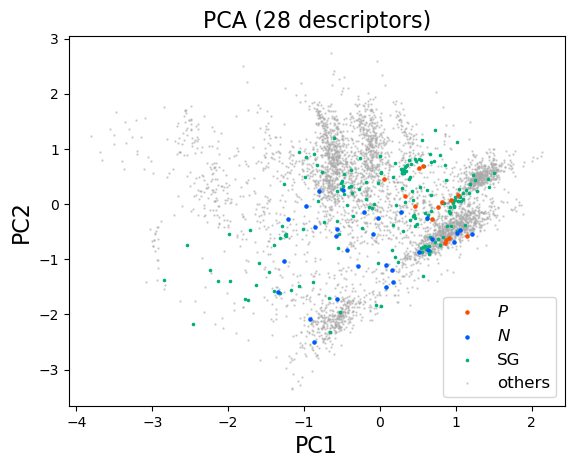

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
p1_if = (df_c.set_index('smiles')['SG'] != 1) & (df_c.set_index('smiles')['pun'] == 0)
p2_if = df_c.set_index('smiles')['SG'] == 1
p3_if = df_c.set_index('smiles')['pun'] == -1
p4_if = df_c.set_index('smiles')['pun'] == 1
p1 = ax.scatter(pca_results[0]['PC1'][p1_if], pca_results[0]['PC2'][p1_if], s=2, c="darkgrey",
                marker=".", alpha=0.5, label="others")
p2 = ax.scatter(pca_results[0]['PC1'][p2_if], pca_results[0]['PC2'][p2_if], s=10, c="#03AF7A",
                marker=".", label="SG")
p3 = ax.scatter(pca_results[0]['PC1'][p3_if], pca_results[0]['PC2'][p3_if], s=20, c="#005AFF",
                marker=".", label="N")
p4 = ax.scatter(pca_results[0]['PC1'][p4_if], pca_results[0]['PC2'][p4_if], s=20, c="#FF4B00",
                marker=".", label="P")
ax.set_xlabel("PC1", fontsize=16)
ax.set_ylabel("PC2", fontsize=16)
ax.set_title("PCA (28 descriptors)", fontsize=16)
handles = [p4, p3, p2, p1]
labels = ["$\it{P}$", "$\it{N}$", p2.get_label(), p1.get_label()]
ax.legend(handles, labels, loc="lower right", fontsize=12)
plt.savefig("Dimension_reduction/PCA_plot.png", dpi=300)
plt.show()

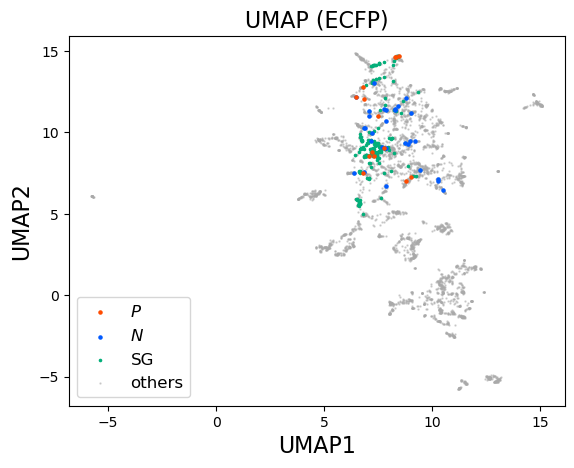

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
p1_if = (df_c.set_index('smiles')['SG'] != 1) & (df_c.set_index('smiles')['pun'] == 0)
p2_if = df_c.set_index('smiles')['SG'] == 1
p3_if = df_c.set_index('smiles')['pun'] == -1
p4_if = df_c.set_index('smiles')['pun'] == 1
p1 = ax.scatter(umap_results['UMAP1'][p1_if], umap_results['UMAP2'][p1_if], s=2, c="darkgrey",
                marker=".", alpha=0.5, label="others")
p2 = ax.scatter(umap_results['UMAP1'][p2_if], umap_results['UMAP2'][p2_if], s=10, c="#03AF7A",
                marker=".", label="SG")
p3 = ax.scatter(umap_results['UMAP1'][p3_if], umap_results['UMAP2'][p3_if], s=20, c="#005AFF",
                marker=".", label="N")
p4 = ax.scatter(umap_results['UMAP1'][p4_if], umap_results['UMAP2'][p4_if], s=20, c="#FF4B00",
                marker=".", label="P")
ax.set_xlabel("UMAP1", fontsize=16)
ax.set_ylabel("UMAP2", fontsize=16)
ax.set_title("UMAP (ECFP)", fontsize=16)
handles = [p4, p3, p2, p1]
labels = ["$\it{P}$", "$\it{N}$", p2.get_label(), p1.get_label()]
ax.legend(handles, labels, loc="lower left", fontsize=12)
plt.savefig("Dimension_reduction/UMAP_plot.png", dpi=300)
plt.show()

# Parameter tuning (28 descriptors)

In [6]:
df_d2 = df_d.copy()
df_d2['pun'] = make_target(df_d2['inchi'], df_k['inchi'], df_k['PN'])
X = df_d2.loc[:, 'm_1_L':'num_Br']
y = df_d2['pun']

In [17]:
df_p, df_n, df_mcc = Parameter_tuning(X, y)

100%|██████████| 5/5 [3:30:13<00:00, 2522.72s/it]  


In [7]:
df_p = pd.read_csv('Parameter_tuning/Parameter_tuning_28descriptors_TPR.csv', index_col=0)
df_n = pd.read_csv('Parameter_tuning/Parameter_tuning_28descriptors_TNR.csv', index_col=0)
df_mcc = pd.read_csv('Parameter_tuning/Parameter_tuning_28descriptors_MCC.csv', index_col=0)

In [8]:
# 28 descriptors
n_estimators_li = [100, 200, 300, 400, 500]

for n_estimators in n_estimators_li:
    p = df_p.loc[n_estimators]
    n = df_n.loc[n_estimators]
    mcc = df_mcc.loc[n_estimators]
    Parameter_tuning_vis(p, n, mcc, n_estimators, '28 descriptors')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
df_p.to_csv('Parameter_tuning/Parameter_tuning_28descriptors_TPR.csv')
df_n.to_csv('Parameter_tuning/Parameter_tuning_28descriptors_TNR.csv')
df_mcc.to_csv('Parameter_tuning/Parameter_tuning_28descriptors_MCC.csv')

# Parameter tuning (ECFPs)

In [9]:
df_e2 = df_e.copy()
df_e2['pun'] = make_target(df_e2['inchi'], df_k['inchi'], df_k['PN'])
X = df_e2.loc[:, '1':'2047']
y = df_e2['pun']

In [21]:
df_p, df_n, df_mcc = Parameter_tuning(X, y)

100%|██████████| 5/5 [10:42:54<00:00, 7714.82s/it] 


In [10]:
df_p = pd.read_csv('Parameter_tuning/Parameter_tuning_ECFPs_TPR.csv', index_col=0)
df_n = pd.read_csv('Parameter_tuning/Parameter_tuning_ECFPs_TNR.csv', index_col=0)
df_mcc = pd.read_csv('Parameter_tuning/Parameter_tuning_ECFPs_MCC.csv', index_col=0)

In [11]:
# ECFP
n_estimators_li = [100, 200, 300, 400, 500]

for n_estimators in n_estimators_li:
    p = df_p.loc[n_estimators]
    n = df_n.loc[n_estimators]
    mcc = df_mcc.loc[n_estimators]
    Parameter_tuning_vis(p, n, mcc, n_estimators, 'ECFPs')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [23]:
df_p.to_csv('Parameter_tuning/Parameter_tuning_ECFPs_TPR.csv')
df_n.to_csv('Parameter_tuning/Parameter_tuning_ECFPs_TNR.csv')
df_mcc.to_csv('Parameter_tuning/Parameter_tuning_ECFPs_MCC.csv')

# Fixed_parameter_validation (28 descriptors)

In [12]:
Experiment_data_path = f'{parent_dir}/Experimental_data'
condition_list = glob.glob(f'{Experiment_data_path}/*.csv')

In [20]:
for con in tqdm(condition_list):
    con_name = con.split('/')[-1].split('.')[0]
    df_con = pd.read_csv(con)
    df_d2 = df_d.copy()
    df_d2['pun'] = make_target(df_d2['inchi'], df_con['inchi'], df_con['PN'])
    df_d2 = pd.merge(df_d2, df_con[['inchi', 'ylds']], on='inchi', how='left')
    X = df_d2.loc[:, 'm_1_L':'num_Br']
    y = df_d2['pun']
    ylds = df_d2['ylds']
    smiles = df_d2['smiles']
    df_result = Fixed_parameter_validation(X, y, ylds, smiles, con_name, '28descriptors', 100, 2)
    df_result.to_csv(f'Fixed_parameter_validation/28descriptors/DPS_28descriptors_{con_name}.csv', index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

TPR of K3FeCN6 is 0.9285714285714286


 20%|██        | 1/5 [00:40<02:42, 40.54s/it]

TNR of K3FeCN6 is 0.8


 40%|████      | 2/5 [01:28<02:14, 44.95s/it]

TPR of CuCl is 0.9473684210526315
TPR of Diacetyl is 1.0


 60%|██████    | 3/5 [02:00<01:18, 39.21s/it]

TNR of Diacetyl is 1.0
TPR of MesAcr+BF4- is 0.9


 80%|████████  | 4/5 [03:01<00:47, 47.48s/it]

TNR of MesAcr+BF4- is 0.9982985963419821
TPR of T(p-OMe)PPCo is 0.8888888888888888


100%|██████████| 5/5 [03:26<00:00, 41.38s/it]

TNR of T(p-OMe)PPCo is 1.0


# Fixed_parameter_validation (ECFPs)

In [21]:
for con in tqdm(condition_list):
    con_name = con.split('/')[-1].split('.')[0]
    df_con = pd.read_csv(con)
    df_e2 = df_e.copy()
    df_e2['pun'] = make_target(df_e2['inchi'], df_con['inchi'], df_con['PN'])
    df_e2 = pd.merge(df_e2, df_con[['inchi', 'ylds']], on='inchi', how='left')
    X = df_e2.loc[:, '1':'2047']
    y = df_e2['pun']
    ylds = df_e2['ylds']
    smiles = df_e2['smiles']
    df_result = Fixed_parameter_validation(X, y, ylds, smiles, con_name, 'ECFPs', 100, 10)
    df_result.to_csv(f'Fixed_parameter_validation/ECFPs/DPS_ECFPs_{con_name}.csv', index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

TPR of K3FeCN6 is 0.8571428571428571


 20%|██        | 1/5 [02:16<09:06, 136.71s/it]

TNR of K3FeCN6 is 0.7666666666666667


 40%|████      | 2/5 [04:52<07:24, 148.02s/it]

TPR of CuCl is 0.9473684210526315
TPR of Diacetyl is 0.9166666666666666


 60%|██████    | 3/5 [06:44<04:22, 131.40s/it]

TNR of Diacetyl is 1.0
TPR of MesAcr+BF4- is 0.85


 80%|████████  | 4/5 [09:53<02:34, 154.26s/it]

TNR of MesAcr+BF4- is 0.9902169289663972
TPR of T(p-OMe)PPCo is 0.6666666666666666


100%|██████████| 5/5 [11:21<00:00, 136.33s/it]

TNR of T(p-OMe)PPCo is 1.0


# Predict_unlabeled

In [22]:
df_d_drop = df_d.drop(['smiles', 'inchikey'], axis=1)
df_m = pd.merge(df_c, df_d_drop, on='inchi', how='left')
df_m2 = df_m.copy()

for con in tqdm(condition_list):
    
    con_name = con.split('/')[-1].split('.')[0]
    df_con = pd.read_csv(con)
    
    df_m2['pun'] = make_target(df_m2['inchi'], df_con['inchi'], df_con['PN'])
    X = df_m2.loc[:, 'm_1_L':'num_Br']
    y = df_m2['pun']
    y_pred, dps = Predict_unlabeled(X, y, 100, 2)
    df_m2[f'P(predicted)_{con_name}'] = y_pred
    df_m2[f'DPS_{con_name}'] = dps
    df_m2[f'DPS_{con_name}'] = df_m2[f'DPS_{con_name}'].fillna('P-data')
    df_m2 = df_m2.drop('pun', axis=1)
    df_each_con = df_m2[df_m2[f'P(predicted)_{con_name}'] != 0]
    df_each_con = pd.concat([df_each_con.loc[:, :'num_Br'], df_each_con[f'P(predicted)_{con_name}'], df_each_con[f'DPS_{con_name}']], axis=1)
    PandasTools.AddMoleculeColumnToFrame(df_each_con, 'smiles')
    PandasTools.SaveXlsxFromFrame(df_each_con, f"Predict_unlabeled/Predict_unlabeled_{con_name}.xlsx", size = (200,200))
df_m2.to_csv("Predict_unlabeled/Predict_unlabeled_all.csv", index=False)

100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


In [24]:
for con in condition_list:
    con_name = con.split('/')[-1].split('.')[0]
    dps = df_m2[f'DPS_{con_name}'][df_m2[f'DPS_{con_name}'] != 'P-data'].astype(float)
    dps = [round(x, 3) for x in dps]

    if con_name == 'K3FeCN6':
        con_name = 'K$_3$[Fe(CN)$_6$]' 
    if con_name == 'T(p-OMe)PPCo':
        con_name = 'T($p$-OMe)PPCo'
    if con_name == 'MesAcr+BF4-':
        con_name = 'MesAcr$^+$BF$_4^-$'
    
    dps_distribution(dps, 2400, 3600, 1200, con_name)

<Figure size 480x640 with 0 Axes>

<Figure size 480x640 with 0 Axes>

<Figure size 480x640 with 0 Axes>

<Figure size 480x640 with 0 Axes>

<Figure size 480x640 with 0 Axes>

# Comparison with PN Learning

In [26]:
df_d2 = df_d.copy()
df_d2['pun'] = make_target_PN(df_d2['inchi'], df_k['inchi'], df_k['PN'])
df_test = pd.read_csv('K3FeCN6_test.csv')
df_d2['test'] = [1 if inchi in df_test['inchi'].values else 0 for inchi in df_d2['inchi']]

X = df_d2[df_d2['pun'] != -1].loc[:, 'm_1_L':'num_Br']
X_test = df_d2[df_d2['test'] == 1].loc[:, 'm_1_L':'num_Br']
y = df_d2[df_d2['pun'] != -1]['pun']

In [27]:
clf = RandomForestClassifier(class_weight='balanced', random_state=0)
clf.fit(X, y)
y_pred = clf.predict(X_test)

In [ ]:
# Predictions for unlabeled
X_test_U = df_d2[df_d2['pun'] == -1].loc[:, 'm_1_L':'num_Br']
y_pred_U = clf.predict(X_test_U)
print(y_pred_U.sum())

771


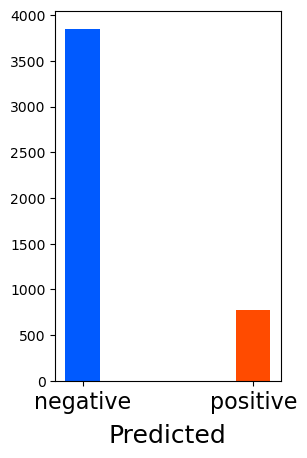

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.bar(['negative', 'positive'], [len(y_pred_U) - y_pred_U.sum(), y_pred_U.sum()], color=['#005AFF', '#FF4B00'], width=0.2)
ax.tick_params(axis='x', labelsize=16) 
fig.suptitle("Predicted", x=0.30, y=0.02, fontsize=18)
fig.savefig('Predict_unlabeled/Predict_unlabeled_PN_K3FeCN6.png', bbox_inches='tight', dpi=300)

In [36]:
df_test2 = df_d2[df_d2['test'] == 1]
df_test2['pred_PN'] = y_pred
df_test3 = pd.merge(df_test, df_test2[['inchi', 'pred_PN']], on='inchi', how='outer')
df_test3 = df_test3[['inchi', 'inchikey', 'smiles_rea', 'ylds', 'BG', 'price/size', 'price/size_unit', 'PN', 'pred_PN']]
df_test3.to_csv('Predict_unlabeled/K3FeCN6_test_result_PN.csv', index=False)

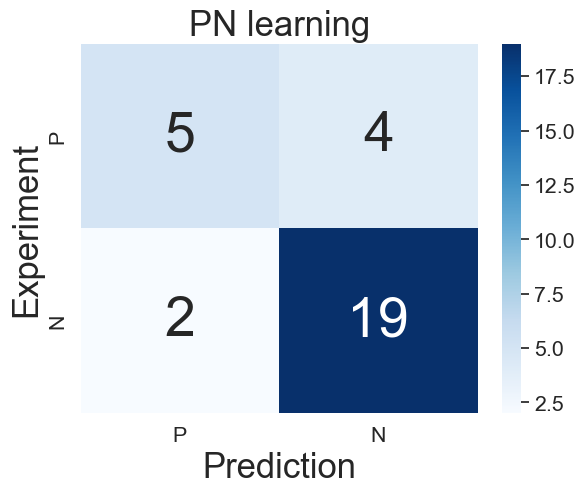

In [37]:
cm_pn = confusion_matrix(df_test3['PN'], df_test3['pred_PN'], labels=[1, 0])
df_cm_pn = pd.DataFrame(cm_pn, columns=['P', 'N'], index=['P', 'N'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm_pn, annot=True, cmap='Blues',
            annot_kws={'fontsize': 40})
plt.title('PN learning', fontsize = 25)
plt.xlabel('Prediction', fontsize = 25)
plt.ylabel('Experiment', fontsize = 25)
plt.savefig('Predict_unlabeled/K3FeCN6_test_CM_PN.png', bbox_inches='tight')

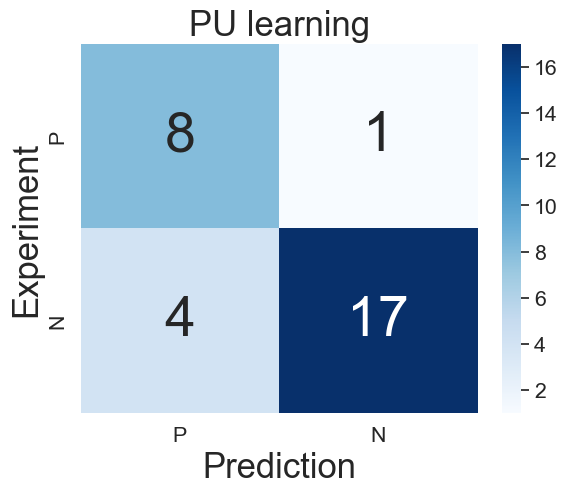

In [38]:
df_pred_k = pd.read_excel('Predict_unlabeled/Predict_unlabeled_K3FeCN6.xlsx')
df_test3['pred_PU'] = [1 if inchi in df_pred_k['inchi'].values else 0 for inchi in df_test3['inchi']]
df_test3 = df_test3.drop('pred_PN', axis=1)
df_test3.to_csv('Predict_unlabeled/K3FeCN6_test_result_PU.csv', index=False)

cm_pu = confusion_matrix(df_test3['PN'], df_test3['pred_PU'], labels=[1, 0])
df_cm_pu = pd.DataFrame(cm_pu, columns=['P', 'N'], index=['P', 'N'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm_pu, annot=True, cmap='Blues',
            annot_kws={'fontsize': 40})
plt.title('PU learning', fontsize = 25)
plt.xlabel('Prediction', fontsize = 25)
plt.ylabel('Experiment', fontsize = 25)
plt.savefig('Predict_unlabeled/K3FeCN6_test_CM_PU.png', bbox_inches='tight')